In [1]:
#import packages
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/jackepstein/Documents/GitHub/wildfires-1001/code/functions/')
from modeling_functions import *
data_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/data'
code_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/code'
model_dir = '/Users/jackepstein/Documents/GitHub/wildfires-1001/models'

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import scale, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA

# Pull in main data frame

In [3]:
#pull in the target data frame and weather dictionary 
#make sure to change the pkl file name if needed
target_dict = {}
target_df = gpd.GeoDataFrame()
for i in np.arange(1, 3):
    target_dict[i] = pd.read_pickle(os.path.join(data_dir, f'clean_data/target_df_final_1123_newtargets_{i}.pkl')) 
    target_df = target_df.append(target_dict[i])


weather_dict_path = os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl')

In [4]:
#load the naming dictionary
with open(weather_dict_path, 'rb') as handle:
    rename_dict = pickle.load(handle)

In [5]:
#rename the columns based on this dictionary
target_df.rename(columns = rename_dict, inplace = True)

In [6]:
#create lists of columns to drop and what our targets are
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR','Index','index']
bad_features = ['hist_p_time_1m', 'total_fire_days', 'hist_p_time_1y','month_id_old']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

In [7]:
#convert floats from 64 to 32 for model
for col in target_df.columns:
    if target_df[col].dtypes == 'float64':
        target_df[col] = target_df[col].astype(np.float32)

# Pull in Models and Feature Lists

In [8]:
#pull in models

#list of models
model_list = ['LR_15PCA_1990_2005.pkl', 'LR_20gini_1990_2005.pkl', 'linSVC_15PCA_1990_2005.pkl', 
              'linSVC_30gini_1990_2005.pkl', 'x-val_LR_30RF_1990_2005.pkl','LR_30entropy_1990_2005.pkl',
              'linSVC_30entropy_1990_2005.pkl','LR_multiclass_25gini_1990_2015.pkl']


#get all paths for loading
model_path_list = []
for m in model_list:
    mod_path = os.path.join(model_dir, m)
    model_path_list.append(mod_path)

#load the models into a dictionary with the file as the key and the model as the value
models = {}
for m in range(len(model_list)):
    with open(model_path_list[m], 'rb') as handle:
        models[model_list[m]] = pickle.load(handle)

In [9]:
#pull in feature lists

#w ill need 30e
feat_list = ['RF_entropy_top30_features.pkl', 'RF_gini_top20_features_1990_2005.pkl', 
             'RF_gini_top30_features_1990_2005.pkl', 'RF_entropy_top35_features.pkl',
             'RF_multi_gini_top25_features_1990_2015.pkl']

#get paths for loading
feat_path_list = []
for f in feat_list:
    feat_path = os.path.join(model_dir,'feature_lists',f)
    feat_path_list.append(feat_path)

features = {}
for f in range(len(feat_list)):
    with open(feat_path_list[f], 'rb') as handle:
        features[feat_list[f]] = pickle.load(handle)

# Split training and testing data

### This is the split where using the 1990-2005 on initial test, 2006-2015 on 2nd stage and 2016-2019 on final testing

In [10]:
#generate phase1 data set
#pre 2006
phase1_data = target_df[target_df['YEAR']<2006]
X_phase1 = phase1_data.drop('YEAR', axis = 1)
#drop columns not used for modeling - dont drop Ys here
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_phase1.drop(y, inplace = True, axis =1)
    except:
        pass
#set up target variable
Y_ph1_cl = phase1_data[['Y_bin_new_fire_month']]
Y_ph1_cl_size = phase1_data[['Y_max_new_fire_size_month']]

#generate phase2 data set - same logic as above
phase2_data = target_df[(target_df['YEAR']>=2006)&(target_df['YEAR']<2016)]
X_phase2 = phase2_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_phase2.drop(y, inplace = True, axis =1)
    except:
        pass
Y_ph2_cl = phase2_data[['Y_bin_new_fire_month']]
Y_ph2_cl_size = phase2_data[['Y_max_new_fire_size_month']]

#generate phase3 (test) data set
phase3_data = target_df[target_df['YEAR']>=2016]
X_phase3 = phase3_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_phase3.drop(y, inplace = True, axis =1)
    except:
        pass
Y_ph3_cl = phase3_data[['Y_bin_new_fire_month']]
Y_ph3_cl_size = phase3_data[['Y_max_new_fire_size_month']]

In [11]:
#scale all data sets
X_phase1_scaled = pd.DataFrame(scale(X_phase1), columns = X_phase1.columns, index=X_phase1.index)
X_phase2_scaled = pd.DataFrame(scale(X_phase2), columns = X_phase2.columns, index=X_phase2.index)
X_phase3_scaled = pd.DataFrame(scale(X_phase3), columns = X_phase3.columns, index=X_phase3.index)

# Perform PCA

In [12]:
#copy base df and re-drop non modeling columns
X_features = target_df.copy()
for y in Y_cols + non_mod_cols + bad_features:
    try:
        X_features.drop(y, inplace = True, axis =1)
    except:
        pass
    
#scale features    
X_features_scaled = scale(X_features)    

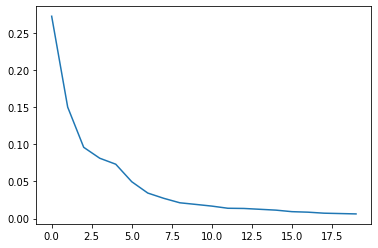

In [13]:
#fit the scaled dataset
pca_x = PCA().fit(X_features_scaled)

#plot explained variance ratio
plt.plot(pca_x.explained_variance_ratio_[0:20])

In [14]:
pca_df = pd.DataFrame(pca_x.components_[0:20,].transpose(), columns = ["PC{}".format(i+1) for i in range(20)], \
                      index = X_features.columns)

In [15]:
#write for loop to make list "nth_principle_component"
princ_comp_list = []
for name in range(1,173):
    pr = str(name)+'th_pc'
    princ_comp_list.append(pr)    

In [16]:
#do split on 3 phases -- still need to do 3 phase split as well
X_features_pca = pd.DataFrame(pca_x.transform(X_features_scaled), columns = princ_comp_list)
X_features_pca['YEAR'] = target_df['YEAR']

#split phases on year
X_ph1_pca = X_features_pca[X_features_pca['YEAR']< 2006]
X_ph2_pca = X_features_pca[(X_features_pca['YEAR']>=2006)&(X_features_pca['YEAR']<2016)]
X_ph3_pca = X_features_pca[X_features_pca['YEAR']>=2016]


Y_ph1_pca = target_df[target_df['YEAR']<2006]['Y_bin_new_fire_month']
Y_ph1_size_pca = target_df[target_df['YEAR']<2006]['Y_max_new_fire_size_month']

Y_ph2_pca = target_df[(target_df['YEAR']>=2006)&(target_df['YEAR']<2016)]['Y_bin_new_fire_month']
Y_ph2_size_pca = target_df[(target_df['YEAR']>=2006)&(target_df['YEAR']<2016)]['Y_max_new_fire_size_month']

Y_ph3_pca = target_df[target_df['YEAR']>=2016]['Y_bin_new_fire_month']
Y_ph3_size_pca = target_df[target_df['YEAR']>=2016]['Y_max_new_fire_size_month']

## Pick model and Get Trained Predictions

ASPECTS TO TEST
- LR vs SVM
- REGULARIZATION PARAMETERS
- PCA vs DATA
- Number of Features/Principle Components
- Try one test with Predictions as a feature rather than a filtering device

In [17]:
#slim down to feature list rather than PCs
#use 'RF_gini_top20_features_1990_2005.pkl'
X_ph1 = X_phase1_scaled[features['RF_entropy_top30_features.pkl']]
X_ph2 = X_phase2_scaled[features['RF_entropy_top30_features.pkl']]
X_ph3 = X_phase3_scaled[features['RF_entropy_top30_features.pkl']]


#pick model
#picking 'x-val_LR_30RF_1990_2005.pkl'
X_phase1_scaled
model = models['x-val_LR_30RF_1990_2005.pkl'].fit(X_ph1, Y_ph1_cl.to_numpy().ravel())
model

LogisticRegression(C=0.01, class_weight='balanced')

In [18]:
#slim down features - was needed when using a PCA model as a phase 1
X_ph1_15 = X_ph1_pca[X_ph1_pca.columns[0:15]]
X_ph2_15 = X_ph2_pca[X_ph2_pca.columns[0:15]]
X_ph3_15 = X_ph3_pca[X_ph3_pca.columns[0:15]]

In [19]:
#run model on train and test sets to get predictions
y_preds_ph2 = model.predict(X_ph2)
y_preds_ph3 = model.predict(X_ph3)

In [20]:
#store predictions and filter -- phase 2

#append the these predictions to the dataframe
preds2_df = pd.DataFrame(y_preds_ph2, columns=['preds'], index=X_ph2_pca.index)
X_ph2_pca_preds = X_ph2_pca.merge(preds2_df, how='outer', left_index=True, right_index=True)

#rejoin with the y-size column
X_ph2_pca_ysize = X_ph2_pca_preds.merge(Y_ph2_size_pca, how='outer', left_index=True, right_index=True)



#store predictions and filter -- phase 3

#append the these predictions to the dataframe
preds3_df = pd.DataFrame(y_preds_ph3, columns=['preds'], index=X_ph3_pca.index)
X_ph3_pca_preds = X_ph3_pca.merge(preds3_df, how='outer', left_index=True, right_index=True)

#rejoin with the y-size column
X_ph3_pca_ysize = X_ph3_pca_preds.merge(Y_ph3_size_pca, how='outer', left_index=True, right_index=True)

In [21]:
#repeat this process for the standard scaled data set

#append the these predictions to the dataframe
preds2_df2 = pd.DataFrame(y_preds_ph2, columns=['preds'], index=X_phase2_scaled.index)
X_ph2_scaled_preds = X_phase2_scaled.merge(preds2_df2, how='outer', left_index=True, right_index=True)

#rejoin with the y-size column
X_ph2_scaled_ysize = X_ph2_scaled_preds.merge(Y_ph2_cl_size, how='outer', left_index=True, right_index=True)



#store predictions and filter -- phase 3

#append the these predictions to the dataframe
preds3_df2 = pd.DataFrame(y_preds_ph3, columns=['preds'], index=X_phase3_scaled.index)
X_ph3_scaled_preds = X_phase3_scaled.merge(preds3_df2, how='outer', left_index=True, right_index=True)

#rejoin with the y-size column
X_ph3_scaled_ysize = X_ph3_scaled_preds.merge(Y_ph3_cl_size, how='outer', left_index=True, right_index=True)

# Using positive predictions as a filter (rather than a feature)

#### Get test and training sets and targets ready

In [22]:
#filter for the positive predicted instances
X_ph2_pca_cut = X_ph2_pca_ysize.loc[X_ph2_pca_ysize['preds']==1]
X_ph3_pca_cut = X_ph3_pca_ysize.loc[X_ph3_pca_ysize['preds']==1]
X_ph2_scaled_cut = X_ph2_scaled_ysize.loc[X_ph2_scaled_ysize['preds']==1]
X_ph3_scaled_cut = X_ph3_scaled_ysize.loc[X_ph3_scaled_ysize['preds']==1]


#drop preds and class_size columns, while saving class size as a new training y
Y_ph2_size_pca_cut = X_ph2_pca_cut['Y_max_new_fire_size_month']
Y_ph3_size_pca_cut = X_ph3_pca_cut['Y_max_new_fire_size_month']
Y_ph2_scaled_cut = X_ph2_scaled_cut['Y_max_new_fire_size_month']
Y_ph3_scaled_cut = X_ph3_scaled_cut['Y_max_new_fire_size_month']

X_ph2_pca_ready = X_ph2_pca_cut.drop(columns=['preds','Y_max_new_fire_size_month','YEAR'])
X_ph3_pca_ready = X_ph3_pca_cut.drop(columns=['preds','Y_max_new_fire_size_month','YEAR'])
X_ph2_scaled_ready = X_ph2_scaled_cut.drop(columns=['preds','Y_max_new_fire_size_month'])
X_ph3_scaled_ready = X_ph3_scaled_cut.drop(columns=['preds','Y_max_new_fire_size_month'])

In [23]:
#regularization hyperparam options
cs = [10**i for i in range(-4, 2)] 
pc_nums = [15, 20, 25, 30]
classes = np.array([0,1,2,3])
costs = np.array([0, -1, -10 , -50])

In [24]:
#get the cost matrix
cost_mat = multi_cost_matrix(classes, costs)
cost_mat

array([[  0.   ,  -0.25 ,  -2.5  , -12.5  ],
       [ -1.   ,   0.   ,  -0.225,  -0.245],
       [-10.   ,  -0.9  ,   0.   ,  -0.2  ],
       [-50.   ,  -0.98 ,  -0.8  ,   0.   ]])

In [25]:
colummns_top = ['test', 'EV', 'AUC', 'Recall_bf']
top_score_df = pd.DataFrame(columns=colummns_top)

# Test 1: Logistic Regression - PCA
- Regularization params
- Number of Principle Components

In [26]:
#run LR on all Cs and number of PCs
#store all confusion matrices, AUCs, scores and expected values
aucs_t1 = {}
conf_mats_t1 = {}
evs_t1 = {}

for i in pc_nums:
    #slim down data set to first i PCs
    X_ph2_pca_fit = X_ph2_pca_ready[X_ph2_pca_ready.columns[0:i]]
    X_ph3_pca_score = X_ph3_pca_ready[X_ph3_pca_ready.columns[0:i]]
    
    #create nested dictionary 
    aucs_t1[i] = {}
    conf_mats_t1[i] = {}
    evs_t1[i] = {}
    
    for c in cs:
        lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_pca_fit, 
                                                                                   Y_ph2_size_pca_cut.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_size_pca_cut, lr.predict(X_ph3_pca_score), normalize='true')
        conf_mats_t1[i][c] = cm
        ev = EV_multi(Y_ph3_size_pca_cut, lr.predict(X_ph3_pca_score), classes, cost_mat)
        evs_t1[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_size_pca_cut, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_pca_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t1[i][c] = np.mean(aucs_sub)

In [27]:
#get the best expected value from the test
max_evs_t1 = []
max_keys_t1 = []
for d in pc_nums:
    max_ev = max(evs_t1[d].values())
    max_key = max(evs_t1[d], key=evs_t1[d].get)
    max_evs_t1.append(max_ev)
    max_keys_t1.append(max_key)

index_t1 = max_evs_t1.index(max(max_evs_t1)) 
print("# of princtple components for max EV:",pc_nums[index_t1])    
print("regularization weight for max EV:",max_keys_t1[index_t1])
print("Max EV:",max_evs_t1[index_t1])

# of princtple components for max EV: 15
regularization weight for max EV: 0.0001
Max EV: -3.6170345880190524


In [28]:
#for above params, get the AUC, EV and big fire recall
top_score_df
temp_df = pd.DataFrame([['t1',max_evs_t1[index_t1],
                         aucs_t1[pc_nums[index_t1]][max_keys_t1[index_t1]],
                         conf_mats_t1[pc_nums[index_t1]][max_keys_t1[index_t1]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

# Test 2: SVM - PCA
- Regularization params
- Number of Principle Components

In [29]:
#run SVM on all Cs and number of PCs
#store all confusion matrices, AUCs, scores and expected values
aucs_t2 = {}
conf_mats_t2 = {}
evs_t2 = {}

for i in pc_nums:
    #slim down data set to first i PCs
    X_ph2_pca_fit = X_ph2_pca_ready[X_ph2_pca_ready.columns[0:i]]
    X_ph3_pca_score = X_ph3_pca_ready[X_ph3_pca_ready.columns[0:i]]
    
    #create nested dictionary 
    aucs_t2[i] = {}
    conf_mats_t2[i] = {}
    evs_t2[i] = {}
    
    for c in cs:
        svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_pca_fit, 
                                                                                   Y_ph2_size_pca_cut.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_size_pca_cut, svm.predict(X_ph3_pca_score), normalize='true')
        conf_mats_t2[i][c] = cm
        ev = EV_multi(Y_ph3_size_pca_cut, svm.predict(X_ph3_pca_score), classes, cost_mat)
        evs_t2[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_size_pca_cut, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_pca_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t2[i][c] = np.mean(aucs_sub)

In [30]:
#get the best expected value from the test
max_evs_t2 = []
max_keys_t2 = []
for d in pc_nums:
    max_ev = max(evs_t2[d].values())
    max_key = max(evs_t2[d], key=evs_t2[d].get)
    max_evs_t2.append(max_ev)
    max_keys_t2.append(max_key)

index_t2 = max_evs_t2.index(max(max_evs_t2)) 
print("# of princtple components for max EV:",pc_nums[index_t2])    
print("regularization weight for max EV:",max_keys_t2[index_t2])
print("Max EV:",max_evs_t2[index_t2])

# of princtple components for max EV: 25
regularization weight for max EV: 0.1
Max EV: -6.963973710850537


In [31]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t2',max_evs_t2[index_t2],
                         aucs_t2[pc_nums[index_t2]][max_keys_t2[index_t2]],
                         conf_mats_t2[pc_nums[index_t2]][max_keys_t2[index_t2]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

# Test 3: Logistic Regression - Feature Selection

- Regularization params
- Features (can pick from list)

In [32]:
feat_list_keys = list(features.keys())

In [33]:
#run LR on all Cs and features
#store all confusion matrices, AUCs, scores and expected values
aucs_t3 = {}
conf_mats_t3 = {}
evs_t3 = {}

for i in feat_list_keys:
    #slim down data set our top features
    X_ph2_feat_fit = X_ph2_scaled_ready[features[i]]
    X_ph3_feat_score = X_ph3_scaled_ready[features[i]]
    
    #create nested dictionary 
    aucs_t3[i] = {}
    conf_mats_t3[i] = {}
    evs_t3[i] = {}
    
    for c in cs:
        lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_feat_fit, 
                                                                                   Y_ph2_scaled_cut.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_scaled_cut, lr.predict(X_ph3_feat_score), normalize='true')
        conf_mats_t3[i][c] = cm
        ev = EV_multi(Y_ph3_scaled_cut, lr.predict(X_ph3_feat_score), classes, cost_mat)
        evs_t3[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_scaled_cut, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_feat_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t3[i][c] = np.mean(aucs_sub)

In [34]:
#get the best expected value from the test
max_evs_t3 = []
max_keys_t3 = []
for f in feat_list_keys:
    max_ev = max(evs_t3[f].values())
    max_key = max(evs_t3[f], key=evs_t3[f].get)
    max_evs_t3.append(max_ev)
    max_keys_t3.append(max_key)

index_t3 = max_evs_t3.index(max(max_evs_t3)) 
print("Feature list for max EV:",feat_list_keys[index_t3])    
print("regularization weight for max EV:",max_keys_t3[index_t3])
print("Max EV:",max_evs_t3[index_t3])

Feature list for max EV: RF_gini_top30_features_1990_2005.pkl
regularization weight for max EV: 10
Max EV: -3.3131792259690567


In [35]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t3',max_evs_t3[index_t3],
                         aucs_t3[feat_list_keys[index_t3]][max_keys_t3[index_t3]],
                         conf_mats_t3[feat_list_keys[index_t3]][max_keys_t3[index_t3]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

# Test 4: SVM- Feature Selection

- Regularization params
- Features (can pick from list)

In [36]:
#run SVM on all Cs and features
#store all confusion matrices, AUCs, scores and expected values
aucs_t4 = {}
conf_mats_t4 = {}
evs_t4 = {}

for i in feat_list_keys:
    #slim down data set our top features
    X_ph2_feat_fit = X_ph2_scaled_ready[features[i]]
    X_ph3_feat_score = X_ph3_scaled_ready[features[i]]
    
    #create nested dictionary 
    aucs_t4[i] = {}
    conf_mats_t4[i] = {}
    evs_t4[i] = {}
    
    for c in cs:
        svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_feat_fit, 
                                                                                   Y_ph2_scaled_cut.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_scaled_cut, svm.predict(X_ph3_feat_score), normalize='true')
        conf_mats_t4[i][c] = cm
        ev = EV_multi(Y_ph3_scaled_cut, svm.predict(X_ph3_feat_score), classes, cost_mat)
        evs_t4[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_scaled_cut, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_feat_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t4[i][c] = np.mean(aucs_sub)

In [37]:
#get the best expected value from the test
max_evs_t4 = []
max_keys_t4 = []
for f in feat_list_keys:
    max_ev = max(evs_t4[f].values())
    max_key = max(evs_t4[f], key=evs_t4[f].get)
    max_evs_t4.append(max_ev)
    max_keys_t4.append(max_key)

index_t4 = max_evs_t4.index(max(max_evs_t4)) 
print("Feature list for max EV:",feat_list_keys[index_t4])    
print("regularization weight for max EV:",max_keys_t4[index_t4])
print("Max EV:",max_evs_t4[index_t4])

Feature list for max EV: RF_entropy_top30_features.pkl
regularization weight for max EV: 0.1
Max EV: -6.4521310049101865


In [38]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t4',max_evs_t4[index_t4],
                         aucs_t4[feat_list_keys[index_t4]][max_keys_t4[index_t4]],
                         conf_mats_t4[feat_list_keys[index_t4]][max_keys_t4[index_t4]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

# Test Having Predicted Positive as a feature rather than a filter
- Append the predicitons -- but don't cut
- Do with the feature data set not PCA -- not going to scale this because it is already binary
- Can test both LR/SVM
- Test all feature lists

In [39]:
#X data to use -- uncut with all scaled feature
X_ph2_scaled_ysize
X_ph3_scaled_ysize

#feature sets to use
Y_ph2_cl_size
Y_ph3_cl_size

#check that indeces match up
print(min(Y_ph2_cl_size.index == X_ph2_scaled_ysize.index))
print(min(Y_ph3_cl_size.index == X_ph3_scaled_ysize.index))

True
True


# Test 5: Logistic Regression- Feature Selection (prediction as feature)

In [40]:
#run LR on all Cs and features
#store all confusion matrices, AUCs, scores and expected values
#also storing nominal totals in conf mats
aucs_t5 = {}
conf_mats_t5 = {}
conf_mats_tot_t5 = {}
evs_t5 = {}

for i in feat_list_keys:
    #slim down data set our top features
    feats = features[i].copy()
    feats.append('preds')
    X_ph2_feat_fit = X_ph2_scaled_ysize[feats]
    X_ph3_feat_score = X_ph3_scaled_ysize[feats]
    
    #create nested dictionary 
    aucs_t5[i] = {}
    conf_mats_t5[i] = {}
    conf_mats_tot_t5[i] = {}
    evs_t5[i] = {}
    
    for c in cs:
        lr = LogisticRegression(C=c, max_iter=1500, class_weight = 'balanced').fit(X_ph2_feat_fit, 
                                                                                   Y_ph2_cl_size.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_cl_size, lr.predict(X_ph3_feat_score), normalize='true')
        conf_mats_t5[i][c] = cm
        cm2 = confusion_matrix(Y_ph3_cl_size, lr.predict(X_ph3_feat_score))
        conf_mats_tot_t5[i][c] = cm2
        ev = EV_multi(Y_ph3_cl_size, lr.predict(X_ph3_feat_score), classes, cost_mat)
        evs_t5[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_cl_size, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], lr.predict_proba(X_ph3_feat_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t5[i][c] = np.mean(aucs_sub)

In [41]:
#get best feature list and copy it
feats_pickle = features['RF_entropy_top30_features.pkl'].copy()
#add preds
feats_pickle.append('preds')
#slim phase 3 with that added
X_ph3_pickle = X_ph3_scaled_ysize[feats_pickle]
#pickle this
X_ph3_pickle.to_pickle('MultiClass_DF_Ph3.pkl')

In [42]:
#get the best expected value from the test
max_evs_t5 = []
max_keys_t5 = []
for f in feat_list_keys:
    max_ev = max(evs_t5[f].values())
    max_key = max(evs_t5[f], key=evs_t5[f].get)
    max_evs_t5.append(max_ev)
    max_keys_t5.append(max_key)

index_t5 = max_evs_t5.index(max(max_evs_t5)) 
print("Feature list for max EV:",feat_list_keys[index_t5])    
print("regularization weight for max EV:",max_keys_t5[index_t5])
print("Max EV:",max_evs_t5[index_t5])

Feature list for max EV: RF_entropy_top30_features.pkl
regularization weight for max EV: 0.1
Max EV: -0.882800371262512


In [43]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t5',max_evs_t5[index_t5],
                         aucs_t5[feat_list_keys[index_t5]][max_keys_t5[index_t5]],
                         conf_mats_t5[feat_list_keys[index_t5]][max_keys_t5[index_t5]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

# Test 6: SVM- Feature Selection (prediction as feature)

In [44]:
#run SVM on all Cs and features
#store all confusion matrices, AUCs, scores and expected values
aucs_t6 = {}
conf_mats_t6 = {}
evs_t6 = {}

for i in feat_list_keys:
    #slim down data set our top features
    feats = features[i].copy()
    feats.append('preds')
    X_ph2_feat_fit = X_ph2_scaled_ysize[feats]
    X_ph3_feat_score = X_ph3_scaled_ysize[feats]
    
    #create nested dictionary 
    aucs_t6[i] = {}
    conf_mats_t6[i] = {}
    evs_t6[i] = {}
    
    for c in cs:
        svm = LinearSVC(C=c, class_weight = 'balanced', dual=False).fit(X_ph2_feat_fit, 
                                                                                   Y_ph2_cl_size.to_numpy().ravel())

        cm = confusion_matrix(Y_ph3_cl_size, svm.predict(X_ph3_feat_score), normalize='true')
        conf_mats_t6[i][c] = cm
        ev = EV_multi(Y_ph3_cl_size, svm.predict(X_ph3_feat_score), classes, cost_mat)
        evs_t6[i][c] = ev
        
        #store aucs -- will aggregate after taking an auc for each class -- simple mean
        y = label_binarize(Y_ph3_cl_size, classes=[0,1,2,3])
        n_classes = y.shape[1]
        aucs_sub = np.zeros(n_classes)
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y[:,n], svm.decision_function(X_ph3_feat_score)[:,n])
            aucs_sub = auc(fpr,tpr)
    
        aucs_t6[i][c] = np.mean(aucs_sub)

In [64]:
#get the best expected value from the test
max_evs_t6 = []
max_keys_t6 = []
for f in feat_list_keys:
    max_ev = max(evs_t6[f].values())
    max_key = max(evs_t6[f], key=evs_t6[f].get)
    max_evs_t6.append(max_ev)
    max_keys_t6.append(max_key)

index_t6 = max_evs_t6.index(max(max_evs_t6)) 
print("Feature list for max EV:",feat_list_keys[index_t6])    
print("regularization weight for max EV:",max_keys_t6[index_t6])
print("Max EV:",max_evs_t6[index_t6])

Feature list for max EV: RF_multi_gini_top25_features_1990_2015.pkl
regularization weight for max EV: 0.0001
Max EV: -4.37994950228728


In [46]:
#for above params, get the AUC, EV and big fire recall
temp_df = pd.DataFrame([['t6',max_evs_t6[index_t6],
                         aucs_t6[feat_list_keys[index_t6]][max_keys_t6[index_t6]],
                         conf_mats_t6[feat_list_keys[index_t6]][max_keys_t6[index_t6]][3][3]]], columns=colummns_top)
top_score_df = top_score_df.append(temp_df)

In [61]:
top_score_df

,test,EV,AUC,Recall_bf
0,t1,-3.617035,0.605718,0.481081
0,t2,-6.963974,0.672432,0.183784
0,t3,-3.313179,0.662818,0.378378
0,t4,-6.452131,0.669070,0.156757
0,t5,-0.882800,0.850484,0.504545
0,t6,-4.379950,0.880694,0.490909


In [65]:
conf_mats_t6['RF_multi_gini_top25_features_1990_2015.pkl'][0.0001], conf_mats_t3['RF_gini_top30_features_1990_2005.pkl'][10]

(array([[0.9023951 , 0.02557176, 0.01980911, 0.05222402],
        [0.53884712, 0.0952381 , 0.16541353, 0.20050125],
        [0.3902439 , 0.08536585, 0.19512195, 0.32926829],
        [0.3       , 0.07272727, 0.13636364, 0.49090909]]),
 array([[0.46126761, 0.13820423, 0.19190141, 0.20862676],
        [0.22340426, 0.33687943, 0.27304965, 0.16666667],
        [0.15      , 0.25      , 0.39285714, 0.20714286],
        [0.20540541, 0.20540541, 0.21081081, 0.37837838]]))

# Deep dive into winning test -- test 5

In [47]:
#initiate DF to store all scores for test 5
colummns_t5 = ['list','C', 'EV', 'AUC', 'Recall_bf']
t5_df = pd.DataFrame(columns=colummns_t5)

#for each parameter get the various scores in a df
for j in range(len(feat_list_keys)):
    for k in range(len(cs)):
        temp_df = pd.DataFrame([[feat_list_keys[j],
                                 cs[k],
                                 evs_t5[feat_list_keys[j]][cs[k]],
                                 aucs_t5[feat_list_keys[j]][cs[k]],
                                 conf_mats_t5[feat_list_keys[j]][cs[k]][3][3]]],
                               columns=colummns_t5)
        t5_df = t5_df.append(temp_df)

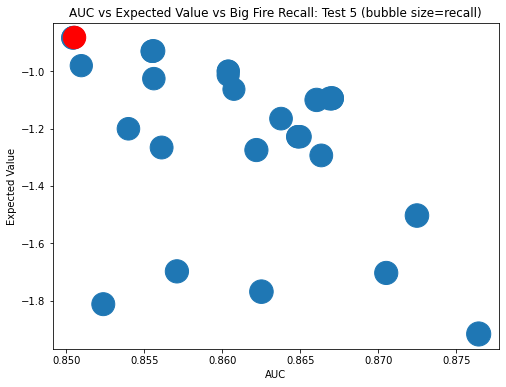

list         RF_entropy_top30_features.pkl
C                                      0.1
EV                                 -0.8828
AUC                               0.850484
Recall_bf                         0.504545
Name: 0, dtype: object

In [48]:
#get best index
ind_max = np.argmax(t5_df['EV'])

#plot bubble chart
plt.figure(figsize=(8,6))
plt.title('AUC vs Expected Value vs Big Fire Recall: Test 5 (bubble size=recall)')
plt.xlabel('AUC')
plt.ylabel('Expected Value')
plt.scatter(t5_df['AUC'], t5_df['EV'],s=t5_df['Recall_bf']*1000)
plt.scatter(t5_df.iloc[ind_max]['AUC'], t5_df.iloc[ind_max]['EV'], s=t5_df.iloc[ind_max]['Recall_bf']*1000, c='red')
plt.show()

np.argmax(t5_df['EV'])
t5_df.iloc[ind_max]

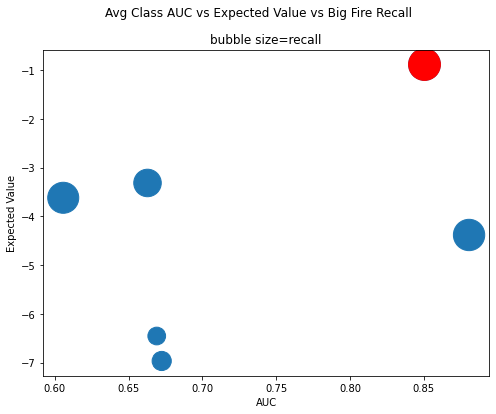

In [49]:
ind_max2 = np.argmax(top_score_df['EV'])

#plot bubble chart
plt.figure(figsize=(8,6))
plt.suptitle('Avg Class AUC vs Expected Value vs Big Fire Recall')
plt.title('bubble size=recall')
plt.xlabel('AUC')
plt.ylabel('Expected Value')
plt.scatter(top_score_df['AUC'], top_score_df['EV'], s=top_score_df['Recall_bf']*2000)
plt.scatter(top_score_df.iloc[ind_max2]['AUC'], top_score_df.iloc[ind_max2]['EV'], 
            s=top_score_df.iloc[ind_max2]['Recall_bf']*2000, c='red')
plt.show()

In [50]:
#get best test confusion matrix
print("Best model confusion matrix:")
print(conf_mats_t5['RF_entropy_top30_features.pkl'][0.1])

Best model confusion matrix:
[[0.68251396 0.11687376 0.09598415 0.10462813]
 [0.13283208 0.3283208  0.30827068 0.23057644]
 [0.07317073 0.24390244 0.37804878 0.30487805]
 [0.04090909 0.2        0.25454545 0.50454545]]


In [51]:
#re-run best model to send to pickle
    #logistic regression with C=0.1
    #feature list - 'RF_gini_top30_features_1990_2005.pkl'
    #includes feature of predicted phase 1

#prep final train data    
feats_final = features['RF_entropy_top30_features.pkl'].copy()
feats_final.append('preds')
X_final = X_ph2_scaled_ysize[feats_final]
X_final    

#run this model
lr_final = LogisticRegression(C=0.1, max_iter=1500, class_weight = 'balanced').fit(X_final, 
                                                                                   Y_ph2_cl_size.to_numpy().ravel())

In [52]:
##Output best LR model:
#with open(os.path.join(model_dir, 'Ensemble_LR_30entropy+preds_ph2.pkl'), 'wb') as handle:
    #pickle.dump(lr_final, handle)

In [53]:
#get test set to use with "baseline mode"
X_sub3 = X_phase3_scaled[features['RF_multi_gini_top25_features_1990_2015.pkl']]


#use non-ensembled multi-class
model_nonphased = models['LR_multiclass_25gini_1990_2015.pkl']

#get preds
baseline_preds = model_nonphased.predict(X_sub3)
baseline_conf = confusion_matrix(Y_ph3_cl_size, baseline_preds)
baseline_conf_scaled = confusion_matrix(Y_ph3_cl_size, baseline_preds, normalize='true')
baseline_ev = EV_multi(Y_ph3_cl_size, baseline_preds, classes, cost_mat)

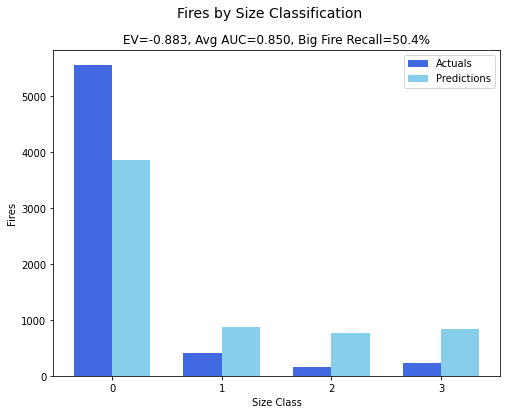

In [54]:
#make the bar chart of predicted vs actuals
mat_to_use = conf_mats_tot_t5['RF_entropy_top30_features.pkl'][0.1]
truth = np.sum(mat_to_use, axis=1)
prediction = np.sum(mat_to_use, axis=0)


#plots
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.suptitle('Fires by Size Classification', fontsize=14)
width=0.35
truth_bar = ax.bar(lr_final.classes_, truth, width, color='royalblue')
pred_bar = ax.bar(lr_final.classes_+width, prediction, width, color='skyblue')

#labels
ax.set_ylabel('Fires')
ax.set_xlabel('Size Class')
ax.set_title('EV=-0.883, Avg AUC=0.850, Big Fire Recall=50.4%')
ax.set_xticks(lr_final.classes_ + width / 2)
ax.set_xticklabels( ('0', '1', '2', '3') )

ax.legend((truth_bar[0], pred_bar[0]), ('Actuals', 'Predictions'))

plt.show()

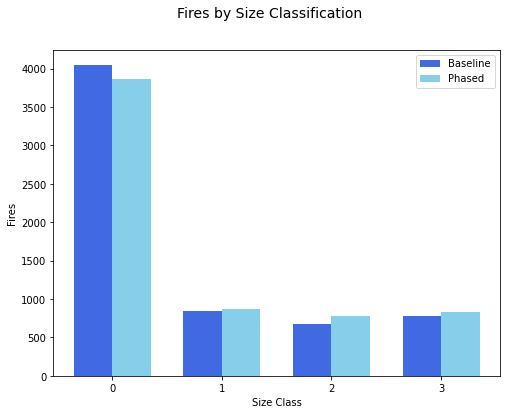

In [55]:
#plot the graph
#make the bar chart of predicted_baseline vs predicted_ensemble
prediction_base = np.sum(baseline_conf, axis=0)
prediction_phased = np.sum(mat_to_use, axis=0)


#plots
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.suptitle('Fires by Size Classification', fontsize=14)
width=0.35
pred_base_bar = ax.bar(lr_final.classes_, prediction_base, width, color='royalblue')
pred_phased_bar = ax.bar(lr_final.classes_+width, prediction_phased, width, color='skyblue')

#labels
ax.set_ylabel('Fires')
ax.set_xlabel('Size Class')
#ax.set_title('EV=-0.883, Avg AUC=0.850, Big Fire Recall=50.4%')
ax.set_xticks(lr_final.classes_ + width / 2)
ax.set_xticklabels( ('0', '1', '2', '3') )

ax.legend((pred_base_bar[0], pred_phased_bar[0]), ('Baseline', 'Phased'))

plt.show()

In [56]:
print("baseline preds by class:",np.sum(baseline_conf, axis=0))
print("phased preds by class:",np.sum(mat_to_use, axis=0))
print("diff by class:",np.sum(mat_to_use, axis=0)-np.sum(baseline_conf, axis=0))

baseline preds by class: [4044  842  670  780]
phased preds by class: [3864  864  774  834]
diff by class: [-180   22  104   54]


In [57]:
#want number of correct big fires predicted
print("Correct preds by class, baseline:",np.diag(baseline_conf))
print("Correct preds by class, phased:",np.diag(mat_to_use))
print("Diff by class:",np.diag(mat_to_use)-np.diag(baseline_conf))

Correct preds by class, baseline: [3938  113   66  110]
Correct preds by class, phased: [3790  131   62  111]
Diff by class: [-148   18   -4    1]
